# Real or Not? NLP with Disaster Tweets

The problem at hand is a standard use case for an NLP solution. We have a dataset that consists of many tweets. Some of these tweets pertain to announcing an emergency and some do not. We need to use Natural Language Processing to calssify which is which.

We are given two files. The first one is `train.csv` which contains the following columns:

- id
- keyword
- location
- text
- target

This file contains about 8,500 tweets that are already classified and need to be used for training our model.

The second file is `test.csv` which contains the following columns:

- id
- keyword
- location
- text

This file contains 3,700 non-classified tweets which will be used to test the model for it's accuracy.

To solve this problem we need to do the following:

- Import the `train.csv` and `test.csv` datasets
- Perform text pre-processing such as 
- Tokenize the processed data
- Train the model using `train.csv`
- Test the model using `test.csv`

Let us begin by importing the necessary libraries such as NumPy, Pandas, NLTK, Scikit-learn and matplotlib.

In [1]:
import numpy as np
import pandas as pd

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import random

nltk.download(['stopwords', 'wordnet'])

[nltk_data] Downloading package stopwords to /home/karan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/karan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
train_csv = "./data/train.csv"
test_csv = "./data/test.csv"
submission_csv = "./data/submission.csv"

We load the datasets using Pandas

In [3]:
train = pd.read_csv(train_csv)
print('Training data shape: ', train.shape)
print(train.head())

print()

test = pd.read_csv(test_csv)
print('Testing data shape: ', test.shape)
print(test.head())

Training data shape:  (7613, 5)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Testing data shape:  (3263, 4)
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typ

Now that the datasets are loaded, we need to begin exploring them.

Firstly, we should see how many columns have missing data and assess if any of these columns will be used to train the model. If yes, we need to try our best to fill them. If not, we can leave them as they are.

Let's see how many values are missing in both datasets for every column:

In [4]:
print("Missing values in training dataset")
print(train.isnull().sum(), end='\n\n')

print("Missing values in testing dataset")
print(test.isnull().sum(), end='\n\n')

Missing values in training dataset
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in testing dataset
id             0
keyword       26
location    1105
text           0
dtype: int64



We know for a fact that the text and the target columns will be used for training. Since both these columns do not have missing data, we can proceed. We will consider filling the remaining columns if need be.

Now, we also need to ensure that there is enough data per class to train the model. For a particular class, if we have too little data to train, we might lose accuracy and if we have too much, we might end up overfitting the data. Since we only have two target values - 0 and 1, let us check the count of both in the training set:

0    4342
1    3271
Name: target, dtype: int64


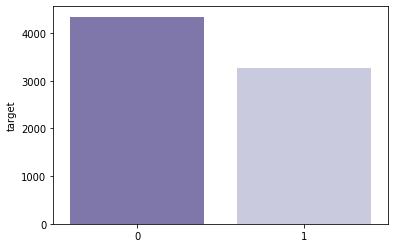

In [5]:
print(train['target'].value_counts())

sns.barplot(train['target'].value_counts().index,
            train['target'].value_counts(), palette='Purples_r')

This is a preview of what a disaster and a non-disaster tweet look like:

In [6]:
# Disaster tweet
disaster_tweets = train[train['target'] == 1]['text']
print(disaster_tweets.values[1])

# Not a disaster tweet
non_disaster_tweets = train[train['target'] == 0]['text']
print(non_disaster_tweets.values[1])

Forest fire near La Ronge Sask. Canada
I love fruits


Let us also see what the Top 20 keywords are in order to understand the trend of the tweets

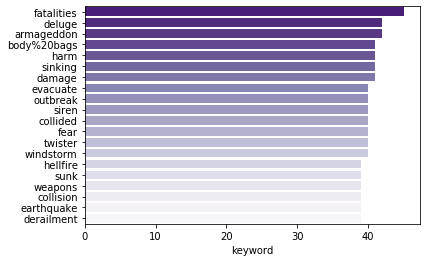

In [7]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,
            x=train['keyword'].value_counts()[:20], orient='h', palette='Purples_r')

Most of these keywords seem to be related to disasters which means we need to explore further.

Let us now see how many times the word "disaster" has been mentioned in the text and a disaster has actually occured

In [8]:
train.loc[train['text'].str.contains(
    'disaster', na=False, case=False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

As we can see, that's about 71% which is something we need to make a note of.

Let us now explore the "location" column

In [9]:
train['location'].value_counts()

USA                         104
New York                     71
United States                50
London                       45
Canada                       29
                           ... 
North West London             1
Holly Springs, NC             1
Ames, Iowa                    1
( ?å¡ ?? ?å¡),                1
London/Bristol/Guildford      1
Name: location, Length: 3341, dtype: int64

We can see that there are too many unique values. We need to cluster them to understand the trend of this data. For now, we will be brute-forcing this but I am sure that there are better ways to do this.

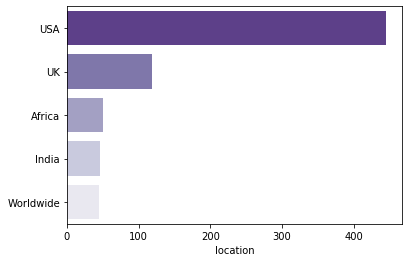

In [10]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States': 'USA',
                           'New York': 'USA',
                           "London": 'UK',
                           "Los Angeles, CA": 'USA',
                           "Washington, D.C.": 'USA',
                           "California": 'USA',
                           "Chicago, IL": 'USA',
                           "Chicago": 'USA',
                           "New York, NY": 'USA',
                           "California, USA": 'USA',
                           "FLorida": 'USA',
                           "Nigeria": 'Africa',
                           "Kenya": 'Africa',
                           "Everywhere": 'Worldwide',
                           "San Francisco": 'USA',
                           "Florida": 'USA',
                           "United Kingdom": 'UK',
                           "Los Angeles": 'USA',
                           "Toronto": 'Canada',
                           "San Francisco, CA": 'USA',
                           "NYC": 'USA',
                           "Seattle": 'USA',
                           "Earth": 'Worldwide',
                           "Ireland": 'UK',
                           "London, England": 'UK',
                           "New York City": 'USA',
                           "Texas": 'USA',
                           "London, UK": 'UK',
                           "Atlanta, GA": 'USA',
                           "Mumbai": "India"}, inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,
            x=train['location'].value_counts()[:5], orient='h', palette='Purples_r')

In [11]:
train['location'].value_counts()

USA                         445
UK                          118
Africa                       51
India                        46
Worldwide                    45
                           ... 
Quito, Ecuador.               1
Im Around ... Jersey          1
New Brunswick, NJ             1
England.                      1
London/Bristol/Guildford      1
Name: location, Length: 3312, dtype: int64

As we can see, the clustering is much better now

---

Now, we begin exploring the most important column which is the "text" column

In [12]:
train['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

Before we begin working on our model, we need to clean up the text column. There are a few basic transformations we can do such as making the text lowercase, removing special symbols, removing links and removing words containing numbers like so:

In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

disaster_tweets = disaster_tweets.apply(lambda x: clean_text(x))
non_disaster_tweets = non_disaster_tweets.apply(lambda x: clean_text(x))

# Let's take a look at the updated text
print(train['text'].head())
print()
print(test['text'].head())

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

0                   just happened a terrible car crash
1    heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3                apocalypse lighting spokane wildfires
4          typhoon soudelor kills  in china and taiwan
Name: text, dtype: object


As we can see, the text looks a lot better now. After this, we break each sentence down to a list of words. This process is called tokenization.

In [14]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

Next, we remove common structural words from the sentences. These words occur very frequently and help form the sentence. In this case, these stopwords aren't needed.

In [15]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words


train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
print(train.head())
print()
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))
print(test.head())

   id keyword location                                               text  \
0   1     NaN      NaN  [deeds, reason, earthquake, may, allah, forgiv...   
1   4     NaN      NaN      [forest, fire, near, la, ronge, sask, canada]   
2   5     NaN      NaN  [residents, asked, shelter, place, notified, o...   
3   6     NaN      NaN  [people, receive, wildfires, evacuation, order...   
4   7     NaN      NaN  [got, sent, photo, ruby, alaska, smoke, wildfi...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

   id keyword location                                               text
0   0     NaN      NaN                   [happened, terrible, car, crash]
1   2     NaN      NaN  [heard, earthquake, different, cities, stay, s...
2   3     NaN      NaN  [forest, fire, spot, pond, geese, fleeing, acr...
3   9     NaN      NaN         [apocalypse, lighting, spokane, wildfires]
4  11     NaN      NaN          [typhoon, soudelor, kills, china, taiwan]


After removing the stopwords, we should essentially be left with tokenized keywords. We can see the most common words and their promincence by generating a Wordcloud like so:

Text(0.5, 1.0, 'Non Disaster Tweets')

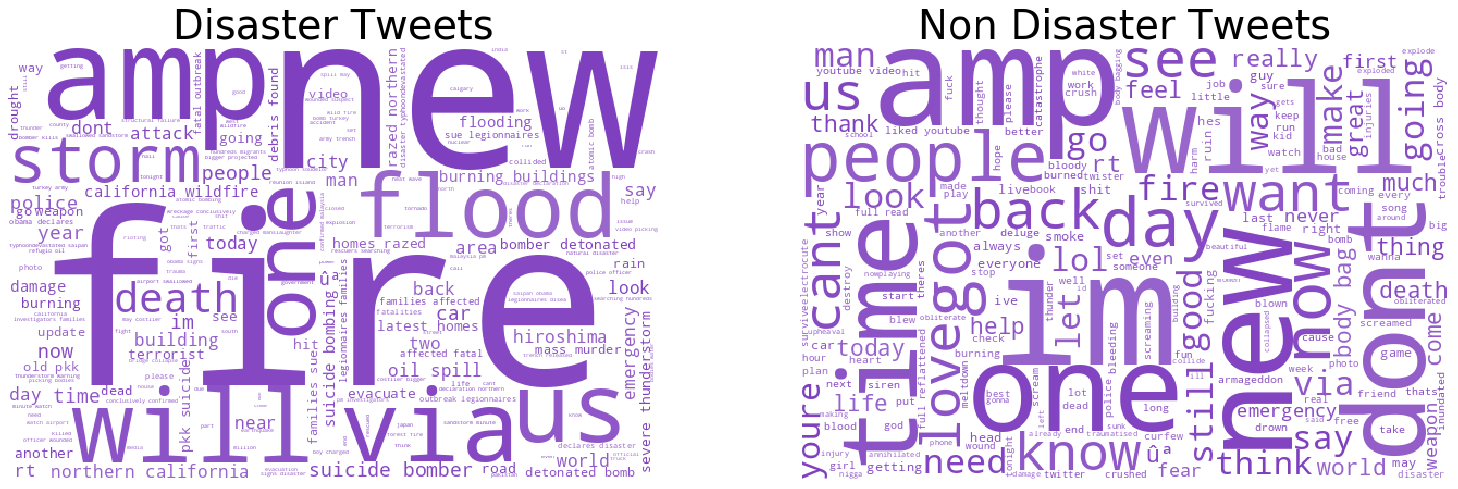

In [16]:
def purple_color_func(word, font_size, position, orientation, random_state=None,
                      **kwargs):
    return "hsl(270, 50%%, %d%%)" % random.randint(50, 60)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud(background_color='white',
                       color_func=purple_color_func,
                       random_state=3,
                       width=600,
                       height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets', fontsize=40)

wordcloud2 = WordCloud(background_color='white',
                       color_func=purple_color_func,
                       random_state=3,
                       width=600,
                       height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets', fontsize=40)

We will now lemmatize these tokens to bring them to their base dictionary form i.e. the lemma

In [17]:
def combine_text(list_of_text):
    combined_text = ' '.join(lemmatizer.lemmatize(token)
                             for token in list_of_text)
    return combined_text


lemmatizer = nltk.stem.WordNetLemmatizer()

train['text'] = train['text'].apply(lambda x: combine_text(x))
test['text'] = test['text'].apply(lambda x: combine_text(x))

print(train['text'].head())
print()
print(test['text'].head())

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: text, dtype: object

0                          happened terrible car crash
1    heard earthquake different city stay safe ever...
2    forest fire spot pond goose fleeing across str...
3                 apocalypse lighting spokane wildfire
4                   typhoon soudelor kill china taiwan
Name: text, dtype: object


---
Now that we're done with pre-processing the text, we can begin working on our model. Before we do that, we need to transform these words to numerical vectors. These vectors tell us the degree of presence of the words. This presence needs to be measured across documents and the count of the "non-informational" words needs to decreased as well. We will be using TF-IDF to achieve this. We need to vectorize both our train and test datasets to use them in our model like so:

In [18]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

print(train_tfidf)
print()
print(test_tfidf)

  (0, 5830)	0.4283910272487035
  (0, 3630)	0.442802667923881
  (0, 212)	0.3877668938463252
  (0, 5829)	0.2746947051361022
  (0, 2800)	0.3039078384184142
  (0, 7604)	0.32581037903448745
  (0, 2328)	0.442802667923881
  (1, 3479)	0.4845040732080171
  (1, 3621)	0.3822396608931049
  (1, 1381)	0.4246053615119869
  (1, 5177)	0.3842811189438505
  (1, 6306)	0.34607258534244945
  (1, 3452)	0.24165665268092038
  (1, 3620)	0.33618860952320734
  (2, 3147)	0.2657764825882111
  (2, 6724)	0.23569671822410906
  (2, 3062)	0.2227770081423819
  (2, 6594)	0.2424595559593297
  (2, 7069)	0.48248657179539656
  (2, 8358)	0.6043165944555675
  (2, 538)	0.2871184150457327
  (2, 7778)	0.29148733099902296
  (3, 3068)	0.4425596400870512
  (3, 1335)	0.3027908527958075
  (3, 10334)	0.3239380496636641
  :	:
  (7611, 2826)	0.401472044402183
  (7611, 1810)	0.14026885071570205
  (7611, 9348)	0.1849947012928698
  (7611, 4820)	0.16272014191955392
  (7611, 8273)	0.16575262991283457
  (7611, 5498)	0.1382488599249523
  (7611, 

Let us begin training our classifier using the vectors we just generated. We will be using a Naive Bayes classifier to classify the tweets in the training dataset. Then, we will use this model to predict the class of the tweets in the test dataset like so:

In [19]:
# Fitting a simple Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(
    clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
print(scores)

[0.57703631 0.58502203 0.62051282 0.60203139 0.74344718]


In [20]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Finally, we can our trained classifier with the tweets from our test set to see how well our classifier is doing. The predictions are stored in the file `data/submission.csv`.

In [21]:
df = pd.DataFrame()
predictions = clf_NB_TFIDF.predict(test_tfidf)
df["id"] = test['id']
df["target"] = predictions
print(df)

df.to_csv(submission_csv, index=False)

         id  target
0         0       1
1         2       0
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       1
3259  10865       0
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]


References:

[Intro to NLP - Kaggle](https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro/data#-2.-Reading-the-datasets)

[NLP Tutorials](https://www.kaggle.com/c/nlp-getting-started/discussion/123030)

[Getting started with feature vectors](https://www.kaggle.com/parulpandey/getting-started-with-nlp-feature-vectors)

[TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform)